# Data Analysis

# Clinic 3: Classification with missing values & inbalanced data

### Participation Grade:
+ Submitting Questions 1-9, would contribute to your participation grade! Please submit within the next few days!
+ Question 10 is open and is left for you to explore how you can improve the model

### Disclaimer:

While this clinic is not delivered (or graded), it is an important and valuable exercise for dealing with several issues that arise in data analysis. Please complete it! It's also a great preparation for the exam!

***
### Learning Goals:

By the end of this clinic, you should be able to:

* Run Classification Models (Logistic Regression, Decision Trees, Random Forests, etc.) in Python
* Explain and tackle issues like missing values or class inbalance in your dataset
* Judge the results of a classification model using AUROC scores
* Select a proper algorithm that works well with your data using techniques (see also last week) like:
    * Cross Validation
    * Regularization

***

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline
import seaborn as sns
sns.set(context='paper')

## Part 1: Determine the Inbalance (Asymmetry)

First, we would like to notice in our data that they are highly unbalanced (assymetric). Load the data which should contain 9 columns (`health`, `age`, `sex`, `educ`, `sexornt`, `partyid`, `race`, `married`, `income`). `Age`, `educ` (how many years of education a person has) and `income` are quantitative, the others are qualitative.

In [2]:
gssdata=pd.read_csv("gssdata4.csv")
gssdata.head()

,health,age,sex,educ,sexornt,partyid,race,married,income
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN


Our goal is to predict if a person is in poor health or not. Let's create some dummy variables in order to measure that.


In [3]:
poorhealth = np.where(gssdata['health'] == 'poor',1,0)
notpoorhealth = np.where(gssdata['health'] != 'poor',1,0)
gssdata['poorhealth'] = poorhealth
gssdata['notpoorhealth'] = notpoorhealth


In [4]:
gssdata.describe()

,age,educ,married,income,poorhealth,notpoorhealth
count,1551.000000,1551.000000,1551.000000,963.000000,1551.000000,1551.000000
mean,48.172792,13.803353,0.732431,15633.177570,0.063830,0.936170
std,17.051151,3.011700,0.442835,5064.191118,0.244528,0.244528
min,18.000000,0.000000,0.000000,500.000000,0.000000,0.000000
25%,33.500000,12.000000,0.000000,13750.000000,0.000000,1.000000
50%,48.000000,14.000000,1.000000,18750.000000,0.000000,1.000000
75%,61.000000,16.000000,1.000000,18750.000000,0.000000,1.000000
max,89.000000,20.000000,1.000000,18750.000000,1.000000,1.000000


**Question 1**

a) Can you quantify what is the degree of inbalance? Mention a percentage of the split between the positive and the negative class.<br>
b) What is the majority and the minority class?<br>
c) What would be the accuracy of a classifier that predicts everybody NOT being in poor health?<br>
d) Discuss (with each other and the teachers) why accuracy is not a good metric.<br>

**Your answer goes here**

In [5]:
####HERE YOU CAN ADD CODE AND MORE COMMENTS
poor_health = gssdata[gssdata['poorhealth'] == True]
poor_health.count()[0]

#99 have poor health out of 1551, so 1452 are healthy
healthy_percentage =(gssdata['poorhealth'].shape[0]- poor_health.count()[0] ) /gssdata['poorhealth'].shape[0]
sick_percentage = poor_health.count()[0] /gssdata['poorhealth'].shape[0]
print(f'% of healthy people '
      f'{healthy_percentage} and of sick  '
      f'{sick_percentage}.')

#There is a great disproportion between the healthy instances 93.6% of the dataset
# and the big minority of 6.4% of sick people. Predicting only healthy woudl give us
# an accuracy of 93%, which is a great number for a model but it does not do its function

% of healthy people 0.9361702127659575 and of sick  0.06382978723404255.


## Part 2: Fit a logistic model ignoring missing values

Let's begin by fitting a logistic regression model to predict poor health based on several of the other predictors in the model. In part 3, you will be asked to regularize (with cross-validation) to make sure you do not overfit, but for this part, we will keep things simple.

First, we need to do a small amount of data clean-up (ignoring missingness for now in `income`). Best practice would be to split into train/test first before looking at the data, but again, we can keep it simple in this part.

If you ignore the missingness `sklearn` might crash (ValueError: Input contains NaN, infinity or a value too large for dtype('float64').) So you can also consider not using that variable in the model

In [6]:
#creating dummies two ways
gssdata['female'] = 1*(gssdata['sex'] ==  'female')
dummy_vars = pd.get_dummies(gssdata[['sexornt','partyid','race']])
gssdata = gssdata.join(dummy_vars)

In [7]:
#Let's get a sense of the data we have
print(gssdata.shape)
gssdata.columns.values
gssdata.head()


(1551, 22)


,health,age,sex,educ,sexornt,partyid,race,married,income,poorhealth,...,sexornt_bisexual,sexornt_dont know,sexornt_heterosexual or straight,sexornt_homosexual or gay,partyid_dem,partyid_other,partyid_rep,race_black,race_other,race_white
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0,0,...,0,0,1,0,0,0,1,0,0,1
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0,0,...,0,0,1,0,0,0,1,0,0,1
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN,0,...,0,0,1,0,0,0,1,0,0,1
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN,0,...,0,0,1,0,0,1,0,0,0,1
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN,1,...,0,0,1,0,0,1,0,0,0,1


**Question 2**

In the code below try to fit your logistic regression model

In [12]:
######HERE YOUR CODE TO FIT THE MODEL
train, test = train_test_split(gssdata, test_size=0.2)
yt = test['poorhealth']
yT = train['poorhealth']
#dataset but without income and target values 
xt = test[[ 'age',  'educ', 
       'married',  'female',
       'sexornt_bisexual', 'sexornt_dont know',
       'sexornt_heterosexual or straight', 'sexornt_homosexual or gay',
       'partyid_dem', 'partyid_other', 'partyid_rep', 'race_black',
       'race_other', 'race_white']]
xT = train[['age',  'educ',
       'married',  'female',
       'sexornt_bisexual', 'sexornt_dont know',
       'sexornt_heterosexual or straight', 'sexornt_homosexual or gay',
       'partyid_dem', 'partyid_other', 'partyid_rep', 'race_black',
       'race_other', 'race_white']]

model = LogisticRegression(random_state=0).fit(xT, yT)
######
######Look up LogisticRegression() from scikitlearn

C:\Users\33789\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
model.score(xt,yt)

0.9196141479099679

---

## 2a: Handling missingness approach \#1: remove observations. 

We do not know how sklearn will treat the missing values (the `NaN`s), so we should do handle them ourselves.  As a base case, let's remove all observations with missingness.

**Question 3**

In the code below, remove all observations that are not complete. Report on how many samples were dropped. Do a quick check to see how dropping observations affected the amount of poor health individuals. Do an appropriate plot to show this (e.g. boxplot) 

In [18]:
# the only variable that has missing values is income
gssdata.isna().any()

#Do a quick check to see how dropping observations affected the amount of poor health individuals
#Do an appropriate plot to show this (e.g. boxplot)

# gssdata_full = gssdata.loc[gssdata['income'] != None] 
gssdata_full = gssdata.dropna()
# print(gssdata[[gssdata['income'].isna]] )
gssdata_full.isna().any()

health                              False
age                                 False
sex                                 False
educ                                False
sexornt                             False
partyid                             False
race                                False
married                             False
income                              False
poorhealth                          False
notpoorhealth                       False
female                              False
sexornt_bisexual                    False
sexornt_dont know                   False
sexornt_heterosexual or straight    False
sexornt_homosexual or gay           False
partyid_dem                         False
partyid_other                       False
partyid_rep                         False
race_black                          False
race_other                          False
race_white                          False
dtype: bool

In [25]:
#Now we will split the data before fitting any models, feel free to change this/adapt this to your taste

from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(range(gssdata_full.shape[0]), test_size=0.25)

#gsstemp = gssdata_full.drop(['health','fairhealth','goodhealth','excellenthealth','sex','sexornt','partyid','race'],axis=1)
gsstemp = gssdata_full[['age','educ','female','partyid_dem','partyid_rep','income']]

X_train = gsstemp.iloc[itrain, :]
X_test = gsstemp.iloc[itest, :]
y_train = gssdata_full['poorhealth'].iloc[itrain]
y_test = gssdata_full['poorhealth'].iloc[itest]

y_train.shape, X_train.shape, y_test.shape, X_test.shape

((722,), (722, 6), (241,), (241, 6))

**Question 4**

Fit a logistic regression mode with C=1000000 (that means that we don't any regularization) and evaluate the classification accuracy on the test set. Discuss whether this accuracy is good/bad.

Then move below to be reminded on the confusion matrix.

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(range(gssdata_full.shape[0]), test_size=0.25)
#####################
# Your code here: fit a logistic model with C=1000000 and evaluate classification accuracy on the test set.
# Then move below to be reminded on the confusion matrix
#####################

logit =  LogisticRegression(C = 1000000)
logit.fit(X_train, y_train)
logit.score(X_test, y_test)

0.983402489626556

## Reminder: The Confusion Matrix & Some Useful Functions

- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix which looks like this:

![confusionmatrix](./confusionmatrix_360.png)


IMPORTANT NOTE: In `sklearn`, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`



In [29]:
#the name of your model should be logit1 (to work with the code below)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,logit.predict(X_test)))

[[237   0]
 [  4   0]]


The following function can be used to create confusion tables with different thresholds (same as we did in the notebook explaing AUROC)

In [30]:
###manually making confusion table from a different threshold
def t_repredict(est, t, xtest):
    probs = est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [32]:
#Try it here!

print(confusion_matrix(y_test,t_repredict(logit, 0.06, X_test)))
print(confusion_matrix(y_train,t_repredict(logit, 0.06, X_train)))

[[226  11]
 [  3   1]]
[[683  27]
 [ 10   2]]


The following fuction should create ROC curves for your models, based on the model and the ground truth. Feel free to change it and improve it!

In [36]:
#making ROC curves for this model
from sklearn.metrics import roc_curve, auc

#name: name of your model to appear on the figure (can be arbitrary)
#clf: the model as you named it - will be used for getting the predictions
#ytest, xtest: your test data
#skip, labe: steps that control how many points you see in the ROC curve and how many labels are there

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM? (but double-check this pleaseee)
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    
    #this is the single value for the AUC score
    roc_auc = auc(fpr, tpr)
    
    if skip: 
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    
    #add labels to the curve
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

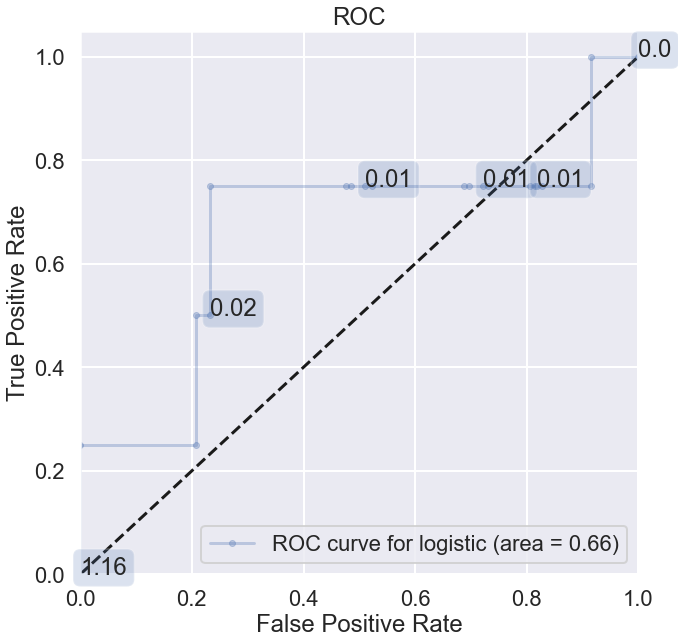

In [37]:
#This is how the above function should be used

sns.set_context("poster")
fig, ax = plt.subplots(figsize = (10,10))
ax=make_roc("logistic",logit, y_test, X_test, labe=4, skip=0)
plt.show()

**Question 5**

What does the above ROC curve tell you about the quality of the model we fit on the data?
Maximizing the threshold that maximizes the TPR and minimizes FPR to achieve better performance of the model, from the ROC curve we see its at 0.1. However, we can see that it performed in terms of FPR, differently in iterations. 

**Your answer goes here**

## Let's get back the data with missingness

It's time to build a model to impute the missing data!

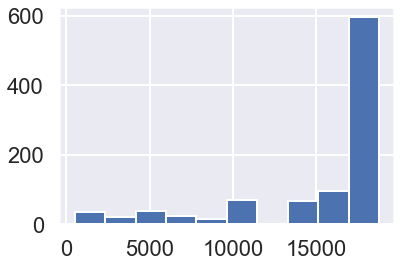

In [38]:
#first build a model to impute using data without missing 
hist = plt.hist(gssdata_full['income'])

---

## 2b: Handling missingness approach \#2: impute the mean 

**Question 6**

In your first approach, make a copy of the original data frame and impute the missing values by assuming that every missing value shoudl be replaced by the mean. Make sure to do a histogram as well and compare it with the original!

Then fit a model (as before in 2a.) and judge the model accuracy. Use the functions for the ROC curve to establish the result.

In [1]:
#back to the original data set with missingness, make a copy, and then impute the mean, plot it!
###YOUR CODE HERE
###
###

In [2]:
###here, do a proper train/test split and a model training


In [4]:
#####################
#your code here: create confusion tables for some thresholds to have an idea of how data looks like
#####################

In [3]:
#####################
# your code here: create an ROC curve
#####################

**Question 7**

What does the above ROC curve tell you about the quality of the model we fit on the data?

**your answer goes here**

---

## 2c: Handling missingness approach \#3: impute with a model (linear regression here)

The third and most sophisticated approach would be to fit a linear model (multiple regression) to estimate income based on the other features (`age`, `educ`, `sex`, `partyid`).

**Question 8**

Train this model below and then use it in order to compute the missing values. The steps should be as follows:

+ figure out which observations have missing values for income,
+ create the values you will use for imputation by:<br>
a) calculating the predicted values for the observations with missingness using the linear model<br>
b) use these values to impute back into the income variable in the missing entries<br>
+ Do a histogram to see how does that look like

In [ ]:
#use the dataset without NAs here
#train a model

#####################
# your code here: 

#####################

Then fill the missing data with the results you got. You can do that multiple ways, one way to use Python would be the following:

In [ ]:
#you might need to change some of the variables below, but in principle it should work
missing_index = gssdata.income[gssdata.income.isnull()].index
missing_series = pd.Series(data = income, index = missing_index)
#back to the data set with missingness and impute the predictions
gssdata_imp = gssdata.copy()
gssdata_imp['income'] = gssdata_imp['income'].fillna(missing_series)

In [ ]:
gssdata_imp['income'].hist(figsize=(7,5))
gssdata_imp['income'].describe()

In [ ]:
#HERE FIT YOUR MODEL AS USUAL FOR PREDICTING THE HEALTH STATUS (POOR OR NOT)
###here, do a proper train/test split and a model training

#Now we will split the data before fitting any models, feel free to change this/adapt this to your taste

In [ ]:
#here you fit a model
#should be called logit3

In [ ]:
#MAKE CONFUSION TABLES FOR DIFFERENT THRESHOLDS AND DRAW THE AUROC CURVE
#####################
# your code here: create an ROC curve
#####################

sns.set_context("poster")
fig, ax = plt.subplots(figsize = (10,10))
#here add code
plt.show()

**Question 9**

Now comment on the performance of difference imputation methods and on the impact it has on the final model performance.


**Your answer goes here**

## Part 3: Improving the model.

**Question 10**

Apply regularization (with cross-validation) to make sure not to overfit to the data and try also different models, like a Decision Tree or a Random Forest. Report on your results for which model handles inbalances in the best way.

**Your checklist**

Here is a checklist for this clinic (classification) made by a TA some years ago.

What are the correlations between variables?<br>
What is the distribution of your variables? How does the histogram look like? <br>
Are there missing values? How can you handle them? <br>
How does dropping missing values affect the distribution? <br>
How does imputing from mean affect the distribution? <br>
How does imputing from model affect the distribution? <br>
How does imputation influence correlation between variables? <br>
What is the difference between precision and accuracy? <br>
What is the difference between Type I and Type II error? <br>
How is a ROC curve build? What do the tresholds represent? <br>
How is the ROC curve affected by dropping NaN? <br>
How is the ROC curve affected by imputing mean? <br>
How is the ROC curve affected by imputing from a model? <br>
What is the difference between overfitting and class imbalance? <br> 
How does the the amount of folds in cross validation affect model performance? <br>

In [ ]:
## your code goes here